**This code notebook tries to generate data from latent diffusion model. It employs MONAI Generative Model. LDM was trained to generate synthetic XRay hand images from MEDNIST. This code was done during tutorial session of MICCAI 2025 summer school.**

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 63.6 MB/s eta 0:00:00


In [ ]:
import monai
print(f"MONAI version: {monai.__version__}")

MONAI version: 1.6.dev2529


Neccessary Imports

In [ ]:
import os
import shutil
import tempfile

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

In [ ]:
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

In [ ]:
!pip install -q "monai-generative" --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 71.0 MB/s eta 0:00:00


In [ ]:
!pip install -q lpips torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

/usr/local/lib/python3.11/dist-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/usr/local/lib/python3.11/dist-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


In [ ]:
print_config()

MONAI version: 1.6.dev2529
Numpy version: 2.0.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a75b1924d44493d0eed607eb77a98cbad3a7ac04
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.53.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io

In [ ]:
set_determinism(44)

Directory Setup

In [ ]:
os.environ["MONAI_DATA_DIRECTORY"] = "/content/sample_data"
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/content/sample_data


In [ ]:
#data download
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)

MedNIST.tar.gz: 59.0MB [00:02, 22.4MB/s]                            

2025-07-21 14:35:10,459 - INFO - Downloaded: /content/sample_data/MedNIST.tar.gz
2025-07-21 14:35:10,572 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-07-21 14:35:10,573 - INFO - Writing into directory: /content/sample_data.



Loading dataset: 100%|██████████| 47164/47164 [00:30<00:00, 1552.95it/s]


In [ ]:
#filtering the hands only images from mednist
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "Hand"]
image_size = 64


In [ ]:
train_datalist

[{'image': '/content/sample_data/MedNIST/Hand/006295.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/008051.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/003515.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/008891.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/002291.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/000052.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/006859.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/009481.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/005313.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/009724.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/000662.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/005476.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/006973.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/005030.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/006445.jpeg'},
 {'image': '/content/sample_data/MedNIST/Hand/009694.jpeg'},
 {'image': '/content/sam

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)

In [ ]:
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualize Examples

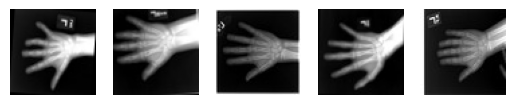

In [ ]:
# Plotexamples from the training set
check_data = first(train_loader)
fig, ax = plt.subplots(nrows=1, ncols=5)
for image_n in range(5):
    ax[image_n].imshow(check_data["image"][image_n, 0, :, :], cmap="gray")
    ax[image_n].axis("off")

Validation Set Preparation


In [ ]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "Hand"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)

2025-07-21 14:35:53,893 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2025-07-21 14:35:53,895 - INFO - File exists: /content/sample_data/MedNIST.tar.gz, skipped downloading.
2025-07-21 14:35:53,895 - INFO - Non-empty folder exists in /content/sample_data/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:07<00:00, 822.84it/s]


**AUTOENCODE+KL**

1)  Main purpose:  itcompresses images into a smaller "latent space" and can reconstruct them back

2) why using: We can decrease the computational resources required to train the diffusion component, making this approach suitable for learning high-resolution medical images.


Basic Architecture

INPUT: Hand X-ray (64×64×1)

    ↓
    
ENCODER:
    Conv Layer (1→128 channels) + 2 ResBlocks

    ↓ (downsample)

    Conv Layer (128→128 channels) + 2 ResBlocks  

    ↓ (downsample)

    Conv Layer (128→256 channels) + 2 ResBlocks
    ↓

LATENT SPACE: (8×8×3) - Compressed representation

    ↓

DECODER:

    Conv Layer (256→128 channels) + 2 ResBlocks

    ↓ (upsample)

    Conv Layer (128→128 channels) + 2 ResBlocks

    ↓ (upsample)  

    Conv Layer (128→1 channels) + 2 ResBlocks

    ↓

OUTPUT: Reconstructed X-ray (64×64×1)

In [ ]:
device = torch.device("cuda")

autoencoderkl = AutoencoderKL(
    spatial_dims=2, #because our images are 2d, we can use spatial_dims=3 for 3d images like ct
    in_channels=1,
    out_channels=1,
    num_channels=(128, 128, 256),
    latent_channels=3,
    num_res_blocks=2,
    attention_levels=(False, False, False),
    with_encoder_nonlocal_attn=False, #turned of attention at both levels only for purpose of faster training, will concurr some loss of mode capacity
    with_decoder_nonlocal_attn=False,
)
autoencoderkl = autoencoderkl.to(device)

In [ ]:
#perceptual loss: a loss function class (from monai) that measures how "perceptually similar" two images are to human vision,
#rather than just pixel-by-pixel differences

perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)
perceptual_weight = 0.001

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 186MB/s]


In [ ]:
#PatchGAN discriminator that classifies image patches rather than whole images

discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=1, out_channels=1)
discriminator = discriminator.to(device)

adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01

In [ ]:
optimizer_g = torch.optim.Adam(autoencoderkl.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

# For mixed precision training
scaler_g = torch.cuda.amp.GradScaler()
scaler_d = torch.cuda.amp.GradScaler()

/tmp/ipython-input-23-3349700240.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_g = torch.cuda.amp.GradScaler()
/tmp/ipython-input-23-3349700240.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_d = torch.cuda.amp.GradScaler()


Training

In [ ]:
kl_weight = 1e-6
n_epochs = 100
val_interval = 10
autoencoder_warm_up_n_epochs = 10

epoch_recon_losses = []
epoch_gen_losses = []
epoch_disc_losses = []
val_recon_losses = []
intermediary_images = []
num_example_images = 4

for epoch in range(n_epochs):
    autoencoderkl.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)

    #Generator Training Step
        with autocast(enabled=True):
            reconstruction, z_mu, z_sigma = autoencoderkl(images)

            recons_loss = F.l1_loss(reconstruction.float(), images.float())
            p_loss = perceptual_loss(reconstruction.float(), images.float())
            kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
            kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
            loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)

            if epoch > autoencoder_warm_up_n_epochs:
                logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                loss_g += adv_weight * generator_loss

        scaler_g.scale(loss_g).backward()
        scaler_g.step(optimizer_g)
        scaler_g.update()

      #Discriminator Training Step
        if epoch > autoencoder_warm_up_n_epochs:
            with autocast(enabled=True):
                optimizer_d.zero_grad(set_to_none=True)

                logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                logits_real = discriminator(images.contiguous().detach())[-1]
                loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

                loss_d = adv_weight * discriminator_loss

            scaler_d.scale(loss_d).backward()
            scaler_d.step(optimizer_d)
            scaler_d.update()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_losses.append(epoch_loss / (step + 1))
    epoch_gen_losses.append(gen_epoch_loss / (step + 1))
    epoch_disc_losses.append(disc_epoch_loss / (step + 1))

    #Validation Loop

    if (epoch + 1) % val_interval == 0:
        autoencoderkl.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = autoencoderkl(images)
                    # Get the first reconstruction from the first validation batch for visualisation purposes
                    if val_step == 1:
                        intermediary_images.append(reconstruction[:num_example_images, 0])

                    recons_loss = F.l1_loss(images.float(), reconstruction.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_losses.append(val_loss)
        print(f"epoch {epoch + 1} val loss: {val_loss:.4f}")
progress_bar.close()

del discriminator
del perceptual_loss
torch.cuda.empty_cache()

Epoch 0:   0%|                                                                        | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-24-416972369.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 9: 100%|██████████████████| 125/125 [00:47<00:00,  2.62it/s, recons_loss=0.024, gen_loss=0, disc_loss=0]
/tmp/ipython-input-24-416972369.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


epoch 10 val loss: 0.0244


Epoch 11:   0%|                                                                       | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-24-416972369.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 19: 100%|██████████| 125/125 [00:51<00:00,  2.42it/s, recons_loss=0.0187, gen_loss=0.3, disc_loss=0.246]


epoch 20 val loss: 0.0192


Epoch 29: 100%|████████| 125/125 [00:51<00:00,  2.41it/s, recons_loss=0.0162, gen_loss=0.276, disc_loss=0.249]


epoch 30 val loss: 0.0179


Epoch 39: 100%|█████████| 125/125 [00:51<00:00,  2.42it/s, recons_loss=0.0161, gen_loss=0.32, disc_loss=0.236]


epoch 40 val loss: 0.0172


Epoch 49: 100%|█████████| 125/125 [00:51<00:00,  2.42it/s, recons_loss=0.0156, gen_loss=0.32, disc_loss=0.231]


epoch 50 val loss: 0.0175


Epoch 59: 100%|█████████| 125/125 [00:52<00:00,  2.39it/s, recons_loss=0.016, gen_loss=0.358, disc_loss=0.211]


epoch 60 val loss: 0.0187


Epoch 69: 100%|████████| 125/125 [00:51<00:00,  2.42it/s, recons_loss=0.0163, gen_loss=0.407, disc_loss=0.202]


epoch 70 val loss: 0.0189


Epoch 79: 100%|████████| 125/125 [00:51<00:00,  2.43it/s, recons_loss=0.0163, gen_loss=0.459, disc_loss=0.186]


epoch 80 val loss: 0.0184


Epoch 89: 100%|█████████| 125/125 [00:51<00:00,  2.43it/s, recons_loss=0.0166, gen_loss=0.417, disc_loss=0.21]


epoch 90 val loss: 0.0196


Epoch 99: 100%|████████| 125/125 [00:51<00:00,  2.43it/s, recons_loss=0.0162, gen_loss=0.434, disc_loss=0.203]


epoch 100 val loss: 0.0194


## Visualise the results from the autoencoderKL

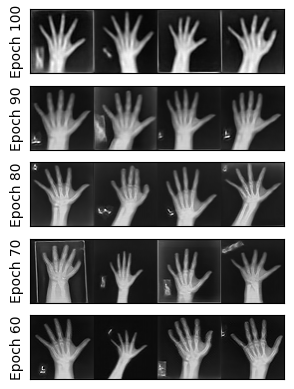

In [ ]:
# Plot last 5 evaluations
val_samples = np.linspace(n_epochs, val_interval, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=5, ncols=1, sharey=True)
for image_n in range(5):
    reconstructions = torch.reshape(intermediary_images[image_n], (image_size * num_example_images, image_size)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

Diffusion Model

In [ ]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
)

scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

In [ ]:
#scaling factor will normalizes the latent space to have the right magnitude for diffusion training

with torch.no_grad():
    with autocast(enabled=True):
        z = autoencoderkl.encode_stage_2_inputs(check_data["image"].to(device))

print(f"Scaling factor set to {1/torch.std(z)}")
scale_factor = 1 / torch.std(z)

Scaling factor set to 0.9616535902023315


/tmp/ipython-input-33-4278897399.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


In [ ]:
inferer = LatentDiffusionInferer(scheduler, scale_factor=scale_factor)


# Full latent diffusion workflow:
# images → autoencoder.encode → latents → scale → diffusion → unscale → autoencoder.decode → images
#                                      ↑_____________inferer handles this part_____________↑

Diffusion Model Training

/tmp/ipython-input-35-589666343.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 0:   0%|                                | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-35-589666343.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 39: 100%|█████████| 125/125 [00:35<00:00,  3.50it/s, loss=0.123]
/tmp/ipython-input-35-589666343.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipython-input-35-589666343.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 39 val loss: 0.1217


100%|██████████| 1000/1000 [00:22<00:00, 43.70it/s]


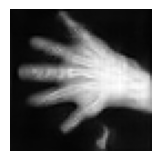

Epoch 40:   0%|                               | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-35-589666343.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 79: 100%|█████████| 125/125 [00:35<00:00,  3.57it/s, loss=0.115]
/tmp/ipython-input-35-589666343.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipython-input-35-589666343.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 79 val loss: 0.1115


100%|██████████| 1000/1000 [00:21<00:00, 45.62it/s]


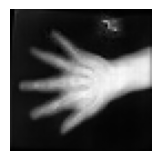

Epoch 80:   0%|                               | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-35-589666343.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 119: 100%|████████| 125/125 [00:35<00:00,  3.50it/s, loss=0.114]
/tmp/ipython-input-35-589666343.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipython-input-35-589666343.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 119 val loss: 0.1147


100%|██████████| 1000/1000 [00:22<00:00, 44.60it/s]


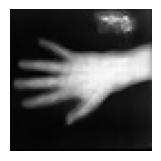

Epoch 120:   0%|                              | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-35-589666343.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 159: 100%|████████| 125/125 [00:35<00:00,  3.54it/s, loss=0.114]
/tmp/ipython-input-35-589666343.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipython-input-35-589666343.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 159 val loss: 0.1167


100%|██████████| 1000/1000 [00:22<00:00, 44.43it/s]


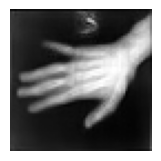

Epoch 160:   0%|                              | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-35-589666343.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
Epoch 199: 100%|████████| 125/125 [00:35<00:00,  3.51it/s, loss=0.107]
/tmp/ipython-input-35-589666343.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):
/tmp/ipython-input-35-589666343.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=True):


Epoch 199 val loss: 0.1140


100%|██████████| 1000/1000 [00:21<00:00, 45.90it/s]


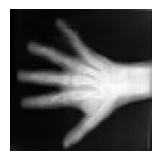

In [35]:
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

unet = unet.to(device)
n_epochs = 200
val_interval = 40
epoch_losses = []
val_losses = []
scaler = GradScaler()

for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(device)
            timesteps = torch.randint(0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device).long()
            noise_pred = inferer(
                inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps, autoencoder_model=autoencoderkl
            )
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_losses.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                with autocast(enabled=True):
                    z_mu, z_sigma = autoencoderkl.encode(images)
                    z = autoencoderkl.sampling(z_mu, z_sigma)

                    noise = torch.randn_like(z).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
                    ).long()
                    noise_pred = inferer(
                        inputs=images,
                        diffusion_model=unet,
                        noise=noise,
                        timesteps=timesteps,
                        autoencoder_model=autoencoderkl,
                    )

                    loss = F.mse_loss(noise_pred.float(), noise.float())

                val_loss += loss.item()
        val_loss /= val_step
        val_losses.append(val_loss)
        print(f"Epoch {epoch} val loss: {val_loss:.4f}")

        # Sampling image during training
        z = torch.randn((1, 3, 16, 16))
        z = z.to(device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            decoded = inferer.sample(
                input_noise=z, diffusion_model=unet, scheduler=scheduler, autoencoder_model=autoencoderkl
            )

        plt.figure(figsize=(2, 2))
        plt.style.use("default")
        plt.imshow(decoded[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()
progress_bar.close()


Learning Curves Plotting

NameError: name 'n_epochs' is not defined

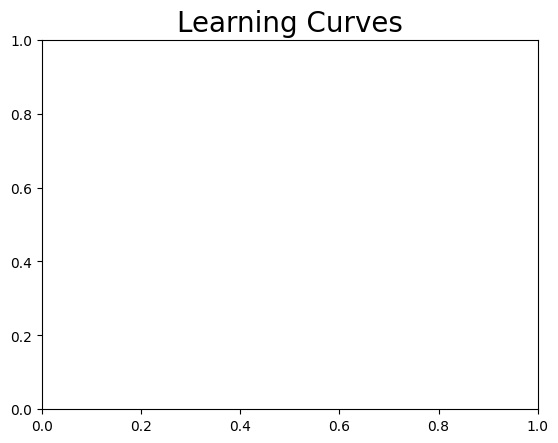

In [3]:
plt.figure()
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_losses, linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)), val_losses, linewidth=2.0, label="Validation"
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})